## Interpolation

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.interpolate import interpn

In [2]:
import pyPLUTO as pp
au = c.au.cgs.value

In [3]:
data = pp.pload.pload(55, datatype='flt', w_dir='data/')

UNIT_DENSITY  = 3.604e-13 # (gr/cm^3)
UNIT_VELOCITY = 6.679e+05 # (cm/s)
UNIT_LENGTH   = 2.992e+14 # (cm)

r = data.x1 * UNIT_LENGTH
th = data.x2
ph = data.x3
rho = data.rho.copy() * UNIT_DENSITY

Reading single data file : data/data.0055.flt


Here are the original data dimensions

In [4]:
r.shape, th.shape, ph.shape

((610,), (172,), (1211,))

In [5]:
rho.shape

(610, 172, 1211)

also a bit tricky: we define the density only grid centers, so there is a gap in phi direction between the last and the first grid center as the interpolation will not know about the periodic direction. We close this here by adding another point beyond $2\pi$ which is a copy of the first point near $\phi = 0$.

In [6]:
ph_mod = np.hstack((ph, 2 * np.pi + ph[0]))
rho_mod = np.concatenate((rho, rho[:, :, 0:1]), axis=2)

We create a cartesian slice, here in the mid-plane `(x, y)` while we call the height `z`

In [7]:
x = np.linspace(-35, 35, 500) * au
y = np.linspace(-35, 35, 510) * au
z = np.array([0])

X, Y, Z = np.meshgrid(x, y, z, indexing='ij')

We translate the coordinates of that slice to spherical coordinates.

Note that phi goes from 0 to $2 \pi$ in the original data, but the output of `np.arctan2` has negative angles and needs to be shifted

In [8]:
R = np.sqrt(X**2 + Y**2 + Z**2)
T = np.pi/2 - np.arctan2(Z, np.sqrt(X**2 + Y**2))
P = (np.arctan2(Y, X) + 2 * np.pi) % (2 * np.pi)

We create a array of new points, shape is (N, 3)

In [9]:
points = np.array([R.ravel(), T.ravel(), P.ravel()]).T

We call the interpolation. There's values outside the box, so we assign them the value `0.0`.

In [10]:
interp = interpn((r, th, ph_mod), rho_mod, points, fill_value=0.0, bounds_error=False)

The result is again one dimensional (one value per new point), so we need to reshape it to match the shape of the slice. After this, it is again 3-dimensional, since our slice has 3 dimensions, but the z-dimension is just one value here.

In [11]:
interp = interp.reshape(X.shape)

Plot it

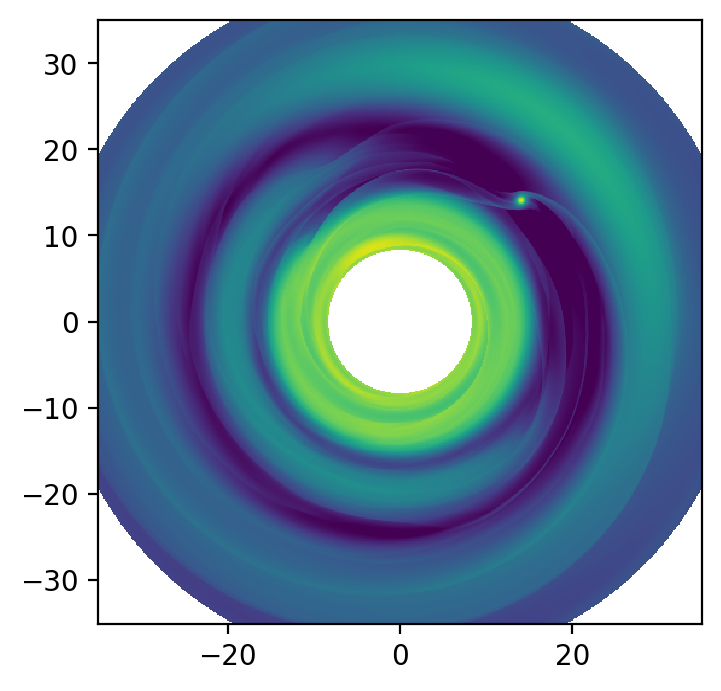

In [12]:
vmax = 10.**np.ceil(np.log10(rho.max()))

f, ax = plt.subplots(dpi=200)
ax.pcolormesh(x / au, y / au, interp[:, :, 0].T, norm=LogNorm(vmin=1e-3 * vmax, vmax=vmax), shading='auto')
ax.set_aspect('equal')